In [1]:
# library imports
from nowcast_lstm.LSTM import LSTM
import numpy as np
import pandas as pd
import torch

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# Data set up

In [3]:
# data read
data = pd.read_csv("../data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("../data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
train_end_date = "2004-12-01"
test_start_date = "2005-03-01"
test_end_date = "2010-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
896,2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
897,2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
898,2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
899,2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN
900,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training the model

In [5]:
model = LSTM(
    data = train,
    target_variable = target_variable,
    n_timesteps = 6,
    fill_na_func = np.nanmean,
    fill_ragged_edges_func = np.nanmean,
    n_models = 10,
    train_episodes = 100,
    batch_size = 50,
    decay = 0.98,
    n_hidden = 10,
    n_layers = 1,
    dropout = 0.0,
    criterion = torch.nn.MSELoss(),
    optimizer = torch.optim.Adam,
    optimizer_parameters = {"lr":1e-2, "weight_decay":0.0}
)
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


# Testing the model on artificial data vintages

In [6]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [7]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        
        # the predict function will give a whole dataframe, only interested in the prediction for this date
        pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
        pred_dict[lag].append(pred)

# Assess and visualize model performance

In [8]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0071
1,-1,0.0051
2,0,0.0045
3,1,0.0040
4,2,0.0037


''

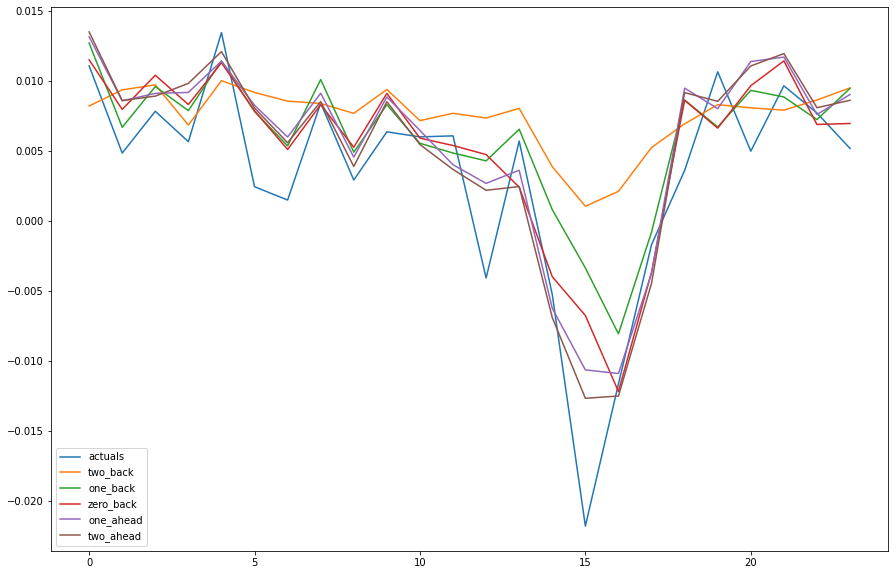

In [9]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Hyperparameter tuning
To hyperparameter tune, you would wrap everything from "Training the model" to "Assess and visualize performance" in a loop and save the performance metrics to a csv. In pseudo code:


```
for hyperparam1 in [option1, option2]:
    for hyperparam2 in [option1, option2]:
    ...
        model = your_model(hyperparam1 = hyperparam1 ...)
        ...
        results = results.append(tmp_results)
results.to_csv("results.csv", index=False)
```

## Below is a list of recommended hyperparameter values to use for grid search with the LSTM if results are not very good with default parameters
- *n_timesteps* (for a quarterly target variable): **[3, 6, 12]**
- *n_timesteps* (for a yearly target variable): **[12, 24]**
- *fill_ragged_edges_func*: **[np.nanmean, "ARMA"]** (warning: ARMA can take a very long time to estimate, the mean is usually capable of getting good predictions and is much faster)
- *n\_models*: **[10]** (this can usually be kept to 10 as a good balance between consistent predictions and estimation time)
- *train_episodes*: **[50, 100, 200]**
- *batch_size*: **[50, 100, 200]**
- *decay*: **[0.98]** (this is fine to keep at the default value of 0.98)
- *n_hidden*: **[10, 20, 40]**
- *n_layers*: **[1, 2, 4]**
- *dropout*: **[0.0]** (this is fine to keep at the default value of 0.0, using `weight_decay` instead for additional regularization if necessary)
- *criterion*: **[torch.nn.L1Loss(), torch.nn.MSELoss()]**
- *optimizer*: **[torch.optim.Adam]** (this is usually fine to keep at the default of Adam)
- *lr*: **[1e-2]** (this is fine to keep at the default value because of the `decay` parameter)
- *weight_decay*: **[0.0]** (this is usually fine to keep at 0.0, neural networks already perform a sort of regularization)

**Note**: `lr` and `weight_decay` should be passed to the `optimizer_parameters` function as a dictionary, e.g. `optimizer_parameters = {"lr": 1e-2, "weight_decay": 0.0}`

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [10]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# obtain prediction for the new period
model.predict(new_data).loc[lambda x: x.date == "2011-03-01","predictions"].values[0]

0.006920450832694769